In [ ]:
# Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
!apt install unzip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# UNZIPPING FILES
# TRAIN FOLDER

# unzipping normal images from train
# !unzip  /content/drive/MyDrive/data_new/train/normal/train.zip -d /content/drive/MyDrive/data_new/train/normal

# unzipping rideshare images from train
# !unzip  /content/drive/MyDrive/data_new/train/rideshare/rideshare.zip -d /content/drive/MyDrive/data_new/train/rideshare

# unzipping normal images from val
# !unzip  /content/drive/MyDrive/data_new/val/Normal/normal.zip -d /content/drive/MyDrive/data_new/val/Normal

# unzipping rideshare images from val
# !unzip  /content/drive/MyDrive/data_new/val/Rideshare/rideshare.zip -d /content/drive/MyDrive/data_new/val/Rideshare

# unzipping test images
!unzip  /content/drive/MyDrive/data_new/test/test.zip -d /content/drive/MyDrive/data_new/test

Archive:  /content/drive/MyDrive/data_new/test/test.zip
  inflating: /content/drive/MyDrive/data_new/test/1q3_W026.jpg  
  inflating: /content/drive/MyDrive/data_new/test/1q3_W026.txt  
  inflating: /content/drive/MyDrive/data_new/test/2q1_W07B.jpg  
  inflating: /content/drive/MyDrive/data_new/test/2q1_W07B.txt  
  inflating: /content/drive/MyDrive/data_new/test/2q1_W026.jpg  
  inflating: /content/drive/MyDrive/data_new/test/2q1_W026.txt  
  inflating: /content/drive/MyDrive/data_new/test/2q3_W026.jpg  
  inflating: /content/drive/MyDrive/data_new/test/2q3_W026.txt  
  inflating: /content/drive/MyDrive/data_new/test/2q4_W026.jpg  
  inflating: /content/drive/MyDrive/data_new/test/2q4_W026.txt  
  inflating: /content/drive/MyDrive/data_new/test/3q1_W026.jpg  
  inflating: /content/drive/MyDrive/data_new/test/3q1_W026.txt  
  inflating: /content/drive/MyDrive/data_new/test/4q1_W02C.jpg  
  inflating: /content/drive/MyDrive/data_new/test/4q1_W02C.txt  
  inflating: /content/drive/MyDriv

In [2]:

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/data_new'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
import numpy

global data
data = []

import pandas as pd
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                train_loss = 0
                train_acc = 0
                val_loss = 0
                val_acc = 0
                row = []
                if phase == 'train':
                  train_loss = epoch_loss
                  train_acc = (epoch_acc.cpu().data.numpy()).item()
                if phase == 'val':
                  val_loss = epoch_loss
                  val_acc = (epoch_acc.cpu().data.numpy()).item()


                data.append([train_loss,train_acc, val_loss, val_acc])


                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        df = pd.DataFrame(data, columns=['train loss', 'train acc', 'val loss', 'val acc'])

    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet50(weights='IMAGENET1K_V2')

# previous model:
# model_ft = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.5MB/s]


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4394 Acc: 0.7993
val Loss: 0.2655 Acc: 0.8927

Epoch 1/24
----------
train Loss: 0.3220 Acc: 0.8578
val Loss: 0.2430 Acc: 0.8893

Epoch 2/24
----------
train Loss: 0.2939 Acc: 0.8758
val Loss: 0.2068 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.2844 Acc: 0.8763
val Loss: 0.2049 Acc: 0.9250

Epoch 4/24
----------
train Loss: 0.2621 Acc: 0.8938
val Loss: 0.2031 Acc: 0.9233

Epoch 5/24
----------
train Loss: 0.2585 Acc: 0.8977
val Loss: 0.2225 Acc: 0.9097

Epoch 6/24
----------
train Loss: 0.2581 Acc: 0.8909
val Loss: 0.1936 Acc: 0.9267

Epoch 7/24
----------
train Loss: 0.2324 Acc: 0.9079
val Loss: 0.1953 Acc: 0.9319

Epoch 8/24
----------
train Loss: 0.2276 Acc: 0.9001
val Loss: 0.1832 Acc: 0.9284

Epoch 9/24
----------
train Loss: 0.2165 Acc: 0.9113
val Loss: 0.1972 Acc: 0.9233

Epoch 10/24
----------
train Loss: 0.2155 Acc: 0.9113
val Loss: 0.1777 Acc: 0.9302

Epoch 11/24
----------
train Loss: 0.2057 Acc: 0.9148
val Loss: 0.1796 Acc: 0.9353

Epoch 12/24
----------
t

In [8]:
print(data)
imagenetv1_e1 = pd.DataFrame(data, columns=['train loss', 'train acc', 'val loss', 'val acc'])
imagenetv1_e1

length = len(imagenetv1_e1)
print(length//2)


start_row = 0
end_row = 2


for i in range(length//2):

  imagenetv1_e1.iloc[start_row] = imagenetv1_e1.iloc[start_row:end_row].sum()
  imagenetv1_e1.drop(start_row+1, axis =0, inplace = True)
  imagenetv1_e1 = imagenetv1_e1.reset_index(drop = True)
  # print(df)

  # print(start_row)
  # print(end_row)

  start_row += 1
  end_row += 1

imagenetv1_e1

[[0.43935702365169393, 0.7993180711154408, 0, 0], [0, 0, 0.26552331262288753, 0.8926746166950597], [0.3219640746175575, 0.8577691183633707, 0, 0], [0, 0, 0.24304834390582686, 0.889267461669506], [0.2939167669776934, 0.8757915245981491, 0, 0], [0, 0, 0.20677945962781802, 0.9216354344122658], [0.284359503325113, 0.8762786166585484, 0, 0], [0, 0, 0.2048662299420399, 0.9250425894378195], [0.262139086892372, 0.8938139308329275, 0, 0], [0, 0, 0.20312723805540872, 0.9233390119250426], [0.258455207937021, 0.8977106673161228, 0, 0], [0, 0, 0.22251208111641016, 0.909710391822828], [0.25813138946760184, 0.890891378470531, 0, 0], [0, 0, 0.19355692862282353, 0.9267461669505963], [0.23235588053697734, 0.9079396005845105, 0, 0], [0, 0, 0.19529354979412622, 0.9318568994889268], [0.2276277859820914, 0.9001461276181199, 0, 0], [0, 0, 0.18317747082929342, 0.9284497444633731], [0.2165253392960087, 0.9113492450073064, 0, 0], [0, 0, 0.1972220166439531, 0.9233390119250426], [0.21553515519400632, 0.9113492450

,train loss,train acc,val loss,val acc
0,0.439357,0.799318,0.265523,0.892675
1,0.321964,0.857769,0.243048,0.889267
2,0.293917,0.875792,0.206779,0.921635
3,0.284360,0.876279,0.204866,0.925043
4,0.262139,0.893814,0.203127,0.923339
5,0.258455,0.897711,0.222512,0.909710
6,0.258131,0.890891,0.193557,0.926746
7,0.232356,0.907940,0.195294,0.931857
8,0.227628,0.900146,0.183177,0.928450
9,0.216525,0.911349,0.197222,0.923339


Text(-4.5, -0.005, 'Stage 1: Finetuning Model Training & Validation Loss & Accuracy for ResNet50 IMAGENET1K_V2')

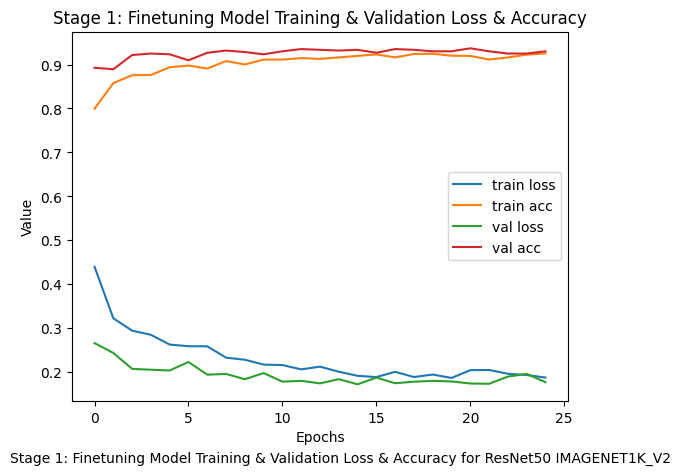

In [58]:
#Plots for Training Stage 1: Finetuning ConvNet Neural Network - All parameters being OPTIMIZED

plot1 = imagenetv1_e1.plot.line()
plot1.set_xlabel("Epochs")
plot1.set_ylabel("Value")
plot1.set_title("Stage 1: Finetuning Model Training & Validation Loss & Accuracy")
txt = 'Stage 1: Finetuning Model Training & Validation Loss & Accuracy for ResNet50 IMAGENET1K_V2'
plot1.text(-4.5, -0.005, txt)
# plot1.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    # img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
    img_path = '/content/drive/MyDrive/data_/test/87q3_W07B.jpg'
)

plt.ioff()
plt.show()